In [24]:
import os.path
import mne

import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib
#matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#%matplotlib tk
import pickle
random.seed(42)

import import_ipynb
from CommonFunctions import loadData, extractDataAndLabels, concatNonEmpty, plot_MVPA, plot_MVPA_Group, prepareData_conf_behavior, prepareData_pred_behavior_conf, splitEpochs_byConfidence, loadDataByParticipant

import pylab, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_rel, sem

import matplotlib.gridspec as gridspec
from scipy.stats import wilcoxon, kruskal

from mne.stats import fdr_correction, bonferroni_correction
from scipy.stats import f_oneway
from statsmodels.stats.oneway import anova_oneway

from statsmodels.stats import multitest

import matplotlib.ticker as ticker


In [33]:
s_ids = ['13', '17', '26', '23', '18', '21', '16', '28', '29', '30', '31', '32', '33',
         '34','35', '36', '38', '39', '40', '41', '42']
#s_ids = ['13', '17', '21', '28', '29', '31', '32', '33', '34', '35', '36', '38', '39', '40'] #subset-1
#s_ids = ['13', '23', '18', '21', '26', '28', '30', '31', '35', '36', '39', '40', '41', '42'] #subset-2

filep = '..\\..\\processed_MEG_Data\MEG_Data\\'
results_folder = '..\\..\\Omissions_MEG_data=-0.1_0.6\\Results\S' 
filep_figures = '..\\..\\Omissions_MEG_data=-0.1_0.6\\Figures\MVPA\\'

print(results_folder)
print(filep_figures)
random.seed(42)
sensors = 'mag'
tlim = 70#140 #70
tlim_lng = 70 #140
task_name = 'all_predLevel' #"all_predLevel" #'all_incorrVScorr'# 'all_conf' #behavior_conf

len(s_ids)

..\..\Omissions_MEG_data=-0.1_0.6\Results\S
..\..\Omissions_MEG_data=-0.1_0.6\Figures\MVPA\


21

In [34]:
min_ind_times = 20 #+70
max_ind_times = 50 #+70
w = [min_ind_times, max_ind_times]

In [35]:
len(s_ids)

21

In [36]:
s_id_tmp = '17'
fname_elongated = filep + 'S' + s_id_tmp + '\\' + s_id_tmp + '_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR.fif' 
epochs_lng, data_real_lng, labels_real_lng, data_omissions_lng, labels_omissions_lng = loadDataByParticipant(s_id_tmp, task_name, fname_elongated, sensors, filep)


Already resampled data!
..\..\processed_MEG_Data\MEG_Data\S17\17_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR_resampled.fif loaded!


In [37]:
def applyWilcoxon(results_group):
    theoreticalLevel = np.asarray([0.5 for i in range(results_group.shape[0])])
    print('theoreticalLevel: ', theoreticalLevel.shape)
    w_group, p_group = [], []
    p_val_corrected_group, reject_group = [], []

    for j in range(results_group.shape[1]):
        data_toCompare = results_group[:, j]
        w_val, p_val = wilcoxon(data_toCompare, theoreticalLevel, alternative='greater')
        w_group.append(w_val)        
        p_group.append(p_val)
        

    w_group = np.asarray(w_group)
    p_group = np.asarray(p_group)
    reject_group, p_val_corrected_group = fdr_correction(p_group, alpha=0.05, method='indep') 
    print('p values: ')
    print(p_group)
    print('corrected p vlaues: ')
    print(p_val_corrected_group)

    return w_group, p_group, p_val_corrected_group


In [38]:
def applySmoothing(data, N):
    
    data_sm = np.zeros((data.shape[0], data.shape[1]-N+1))
            
    #print('shape of data at 0: ', data_0.shape)
    #print('shape of data_sm_0: ', data_sm_0.shape)
    #print('labels: ', labels)
    # smooth:
    for f in range(len(data_sm)):
        data_sm[f] = np.convolve(data[f,:], np.ones((N,))/N, mode='valid')
    
    return data_sm
    

In [39]:
def applyKruskal(x, y, z=None):
    stats, pvals = [], []
    
    for i in range(x.shape[1]):
        if np.all(z) == None:
            #print('comparing 2 groups')
            s,p = kruskal(x[:,i],y[:,i])
        else: 
            #print('comparing 3 groups')
            s,p = kruskal(x[:,i],y[:,i],z[:,i])
    
        
        stats.append(s)
        pvals.append(p)
        
    return stats, pvals

In [40]:
def applyAnova(x, y, z=None):
    res_array = []
    
    for i in range(x.shape[1]):
        if np.all(z) == None:
            #print('comparing 2 groups')
            data = np.asarray([x[:,i],y[:,i]])
        else: 
            #print('comparing 3 groups')
            data = np.asarray([x[:,i],y[:,i],z[:,i]])
    
        res = anova_oneway(data=data, welch_correction=False)
        res_array.append(res.pvalue)
    return res_array

In [41]:

def plot_conditions(data, peakPoint, times, ylabel, plotname, labels=None, isOmi=True, smooth=False, isReal=False, 
                    isPredLevel=True, includeInverted=False, fvalues=None):
    print(peakPoint)
    sns.set(style="white")
    ColorsL = np.array(([194,165,207], [153,112,171], [118,42,131]))/256
    ColorReal = np.array(([27,120,55]))/256
    col_axes = np.array((82, 82, 82))/256
    pval_color = np.array(([128,128,128]))/256

    al = 0.2
    fig = plt.figure(num=None, figsize=(4, 2), dpi=150)
    ax = fig.add_subplot(1,1,1)
    #data = data[:,:,70:]
    N = 10 # Kernel for smoothing
    min_vals = np.zeros((data.shape[1]),)
    if isReal == False:
        if smooth == True:
            # pre-allocate array for smooth results - this will be the same size as original results - N+1 due to kernel
            data_0 = data[:,0,:]
            data_sm_0 = applySmoothing(data_0, N)
            print('ind 0')
            w_sm_0, p_sm_0, p_corrected_sm_0 = applyWilcoxon(data_sm_0)
            epochs_mean = np.mean(data_sm_0, axis = 0)
            min_vals[0] = np.min(epochs_mean)
            epochs_std = sem(data_sm_0, axis = 0)/2
            ax.plot(times[:len(times)-N+1], epochs_mean, color = ColorsL[0], linewidth = 2,  label = labels[0])
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)

            data_1 = data[:,1,:]
            data_sm_1 = applySmoothing(data_1, N)
            print('ind 1')
            w_sm_1, p_sm_1, p_corrected_sm_1 = applyWilcoxon(data_sm_1)
            epochs_mean = np.mean(data_sm_1, axis = 0)
            min_vals[1] = np.min(epochs_mean)
            epochs_std = sem(data_sm_1, axis = 0)/2
            ax.plot(times[:len(times)-N+1], epochs_mean, color = ColorsL[1], linewidth = 2,  label = labels[1])
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color = ColorsL[1], interpolate=True, alpha = al)
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color = ColorsL[1], interpolate=True, alpha = al)

            if isPredLevel == True or includeInverted == True or data.shape[1] > 2:
                data_2 = data[:,2,:]
                data_sm_2 = applySmoothing(data_2, N)
                print('ind 2')
                w_sm_2, p_sm_2, p_corrected_sm_2 = applyWilcoxon(data_sm_2)
                epochs_mean = np.mean(data_sm_2, axis = 0)
                min_vals[2] = np.min(epochs_mean)
                epochs_std = sem(data_sm_2, axis = 0)/2
                
                ax.plot(times[:len(times)-N+1], epochs_mean, color = ColorsL[2], linewidth = 2,  label = labels[2])
                ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color = ColorsL[2], interpolate=True, alpha = al)
                ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color = ColorsL[2], interpolate=True, alpha = al)

                if data.shape[1] == 4:
                    print('here!!!!')
                    data_3 = data[:,3,:]
                    data_sm_3 = applySmoothing(data_3, N)
                    epochs_mean = np.mean(data_sm_3, axis = 0)
                    min_vals[3] = np.min(epochs_mean)
                    epochs_std = sem(data_sm_3, axis = 0)/2

                    ax.plot(times[:len(times)-N+1], epochs_mean, '-.', color = ColorsL[1], linewidth = 2,  label = labels[3])
                    ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color = ColorsL[1], interpolate=True, alpha = al)
                    ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color = ColorsL[1], interpolate=True, alpha = al)


        else:
            w_sm_0, p_sm_0, p_corrected_sm_0 = applyWilcoxon(data[0])
            epochs_mean = np.mean(data[0], axis = 0)
            epochs_std = sem(data[0], axis = 0)/2
            ax.plot(times, epochs_mean, color = ColorsL[0], linewidth = 2,  label = labels[0])
            ax.fill_between(times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
            ax.fill_between(times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
            
            w_sm_1, p_sm_1, p_corrected_sm_1 = applyWilcoxon(data[1])
            epochs_mean = np.mean(data[1], axis = 0)
            epochs_std = sem(data[1], axis = 0)/2
            ax.plot(times, epochs_mean, color = ColorsL[0], linewidth = 2,  label = labels[1])
            ax.fill_between(times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[1], interpolate=True, alpha = al)
            ax.fill_between(times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[1], interpolate=True, alpha = al)
            
            if isPredLevel == True:
                w_sm_2, p_sm_2, p_corrected_sm_2 = applyWilcoxon(data[2])
                epochs_mean = np.mean(data[2], axis = 0)
                epochs_std = sem(data[2], axis = 0)/2
                ax.plot(times, epochs_mean, color = ColorsL[0], linewidth = 2,  label = labels[2])
                ax.fill_between(times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[2], interpolate=True, alpha = al)
                ax.fill_between(times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[2], interpolate=True, alpha = al)
        plt.legend(labels, loc='upper center', bbox_to_anchor=(1.2, 0.7))
    else:
        # pre-allocate array for smooth results - this will be the same size as original results - N+1 due to kernel
        data_0 = data[:,0,:]
        if smooth == True:
            data_sm_0 = applySmoothing(data_0, N)
            #w_sm_0, p_sm_0 = applyWilcoxon(data_sm_0)
            epochs_mean = np.mean(data_sm_0, axis = 0)
            epochs_std = sem(data_sm_0, axis = 0)/2
            
            ax.plot(times[:len(times)-N+1], epochs_mean, color = ColorReal, linewidth = 2)
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color = ColorReal, interpolate=True, alpha = al)
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color = ColorReal, interpolate=True, alpha = al)

                       
        else:
            epochs_mean = np.mean(data_0, axis = 0)
            epochs_std = sem(data_0, axis = 0)/2
            
            print('max: ', np.max(epochs_mean))
            print('argmax: ', np.argmax(epochs_mean))
            ax.plot(times, epochs_mean, color = ColorReal, linewidth = 2,  label = labels[0])
            ax.fill_between(times, epochs_mean, epochs_mean + epochs_std, color = ColorReal, interpolate=True, alpha = al)
            ax.fill_between(times, epochs_mean, epochs_mean - epochs_std, color = ColorReal, interpolate=True, alpha = al)

    print(times)
    if isReal == False:
        if isPredLevel == False or includeInverted == False:
            nLoop = 2
        else:
            nLoop = 3

        for t in range(data.shape[1]):
            for p in range(data.shape[2]-N+1):
                if t==0:
                    p_values_tmp = p_corrected_sm_0
                    #r_values_tmp = r_sm_0
                elif t==1:
                    p_values_tmp = p_corrected_sm_1
                    #r_values_tmp = r_sm_1
                elif t==2:
                    p_values_tmp = p_corrected_sm_2
                    #r_values_tmp = r_sm_2

                if p_values_tmp[p] <= 0.05: #and r_values_tmp[p] == True:
                    y_val = np.min(min_vals)
                    #print(y_val)
                    print('ind of omi: ' + str(t) + ' - ind of val: ' + str(p) + ' - val: ', str(p_values_tmp[p]))
                    print(times[p])
                    ax.plot(times[p], y_val-0.005, color=pval_color, marker='_')


        if np.all(fvalues) != None:
            y_val = np.min(min_vals)
            print(y_val)
            for p in range(data.shape[2]-N+1):
                if fvalues[p] <= 0.05:
                    ax.plot(times[p], y_val-0.005, color=pval_color, marker='_')
    
  
    ax.set_xticks(np.arange(-0.1, 0.6, 0.1))   
    ax.set_ylabel(ylabel)
    #plt.yticks(np.arange(0.1, 0.6, 0.1))
    ax.set_xlabel('Times(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #locator = ticker.FixedLocator([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
    #ax.xaxis.set_major_locator(locator)
    ax.tick_params(axis='x', which='major', length=4)
    ax.xaxis.tick_bottom()
    
    
    #plt.savefig(plotname, bbox_inches='tight')
    return data_sm_0, data_sm_1, data_sm_2
    
    


In [43]:
includeInverted = False

#"all_predLevel" #'all_incorrVScorr'# 'all_conf'
if task_name == "all_predLevel":
    plot_labels = ['80%', ' 90%', '100%']
    plot_file_suf = ['80', '90', '100']
    
elif task_name == "behavior_conf":
    plot_labels = ['Corr & LowConf', 'Corr & HighConf','Incorr & LowConf', 'Incorr & HighConf']
    plot_file_suf = ['corrLow', 'corrHigh', 'incorrLow', 'incorrHigh']
    
elif task_name == 'all_incorrVScorr':
    plot_labels = ['Correct', 'Incorrect']
    plot_file_suf = ['corr', 'incorr']
    
elif task_name == "all_conf":
    plot_labels = ['Low Confidence', 'High Confidence']
    plot_file_suf = ['low', 'high']
    
results_group, results_group_real = [], []
results_group_reversed, results_group_real_reversed = [], []
for s in s_ids:
    #file_reversed = results_folder + s + '\\' + s + "_" + sensors + "_results_" + task_name + "_" + str(w[0]) + '_' + str(w[1])+ '_sm.npy'
    file = results_folder + s + '\\' + s + "_" + sensors + "_results_" + task_name + "_" + str(w[0]) + '_' + str(w[1])+ '_sm_all.npy'
    
    #file = results_folder + s + '/' + s + "_" + sensors +"_results_" +  task_name + "_earlyWin_" + str(w[0])+ '_' +str(w[1]) + ".npy"
    results_MVPA = np.load(file, allow_pickle=True)
    print('shape res: ', len(results_MVPA))
    #results_MVPA_reversed = np.load(file_reversed, allow_pickle=True)
    #print('results_MVPA: ', results_MVPA.shape)
    
    if len(results_MVPA) > 4:
        res = []
        for k in range(1,len(results_MVPA)-1):
            res.append(results_MVPA[k][:])
        print('test res length: ', len(res))    
        #res_reversed = [results_MVPA_reversed[1][:], results_MVPA_reversed[2][:], results_MVPA_reversed[3][:]]
    else:
        res = [results_MVPA[1][:], results_MVPA[2][:]]
        
        if includeInverted == True:
            if 'incorrVScorr' in task_name:
                res.append(results_MVPA_reversed[2][:])
            elif 'conf' in task_name:
                res.append(results_MVPA_reversed[1][:]) 
    
    res_real =  [results_MVPA[0][:]]
    #res_real_reversed = [results_MVPA_reversed[0][:]]
    
    results_group.append(np.asarray(res))
    results_group_real.append(np.asarray(res_real))


shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3
shape res:  5
test res length:  3


In [44]:
results_group = np.asarray(results_group)
print(results_group.shape)
results_group_real = np.asarray(results_group_real)
results_group_real.shape

(21, 3, 70)


(21, 1, 70)

In [14]:
epochs_lng[0].times[70: tlim_lng]

array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
        0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,
        0.17,  0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,
        0.26,  0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,
        0.35,  0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,
        0.44,  0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,
        0.53,  0.54,  0.55,  0.56,  0.57,  0.58,  0.59])

In [15]:
print(results_group.shape)


(21, 3, 140)


In [ ]:
N = 10
omi_8_sm = applySmoothing(results_group[:,0,70:], N)
omi_9_sm = applySmoothing(results_group[:,1,70:], N)
omi_10_sm = applySmoothing(results_group[:,2,70:], N)
omi_10_sm.shape

In [ ]:
pvals = applyAnova(omi_8_sm, omi_9_sm, omi_10_sm) 

In [ ]:
print(pvals)
plt.plot(epochs_lng[0].times[70: tlim_lng-N+1], pvals)
plt.ylabel('p-values')
plt.xlabel('Times(s)')
plt.ylim(ymin=0)
plt.title('One way Anova Results')
plt.show()

In [ ]:
stats, pvals = applyKruskal(omi_8_sm, omi_9_sm, omi_10_sm)

In [ ]:
print(pvals)
plt.plot(epochs_lng[0].times[70: tlim_lng-N+1], pvals)
plt.ylabel('p-values')
plt.xlabel('Times(s)')
plt.ylim(ymin=0)
plt.title('Kruskal-Wallis Test Results')
plt.show()

In [ ]:
results_group.shape

[20, 50]
ind 0
theoreticalLevel:  (21,)
p values: 
[0.19629192 0.25838041 0.31664848 0.30457449 0.24740124 0.37964392
 0.48642921 0.43244362 0.59416103 0.56755638 0.65864325 0.70729876
 0.78404427 0.71896267 0.74161959 0.74161959 0.71896267 0.84809208
 0.80370808 0.65864325 0.54065323 0.47287226 0.35445265 0.30457449
 0.25838041 0.21595573 0.28103733 0.32891369 0.30060635 0.32891369
 0.52712774 0.76333284 0.83977127 0.89854145 0.97490406 0.98247194
 0.96200991 0.96767521 0.97490406 0.96493149 0.95210028 0.97265339
 0.97490406 0.95560074 0.95560074 0.95210028 0.95210028 0.95210028
 0.94032907 0.83977127 0.8838872  0.83117008 0.7723636  0.71896267
 0.44586611 0.05967093 0.04439926 0.10784006 0.07348204 0.04109764
 0.00973654]
corrected p vlaues: 
[0.98247194 0.98247194 0.98247194 0.98247194 0.98247194 0.98247194
 0.98247194 0.98247194 0.98247194 0.98247194 0.98247194 0.98247194
 0.98247194 0.98247194 0.98247194 0.98247194 0.98247194 0.98247194
 0.98247194 0.98247194 0.98247194 0.98247194

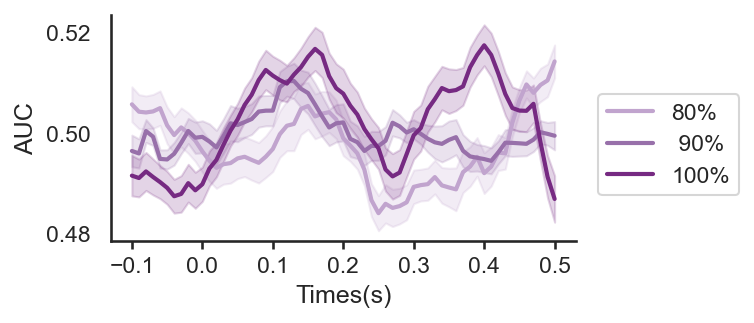

In [46]:
plotname = filep_figures + 'MVPA_GroupLevel_TestOmiScores_all_' +  sensors + '_' + task_name + '_' + str(w[0])+ '_' +str(w[1]) + '_sm_p.png'
w_lng = [w[0], w[1]]
data_sm_0, data_sm_1, data_sm_2 = plot_conditions(results_group, w_lng, epochs_lng[0].times[0: tlim_lng], 'AUC', plotname, labels=plot_labels,
                smooth=True, isPredLevel=False, isReal=False, includeInverted=False)


In [ ]:
plotname = filep_figures + 'MVPA_GroupLevel_TestRealScores_all_tmp_' +  sensors + '_' + task_name + '_' + str(w[0])+ '_' +str(w[1]) + '_sm.png'
w_lng = [w[0], w[1]]
plot_conditions(results_group_real, w_lng, epochs_lng[0].times[70: tlim_lng], 'AUC', plotname, labels=plot_labels,
                smooth=True, isPredLevel=False, isReal=True, includeInverted=False, fvalues=None)


In [72]:
np.save('..\\Results\\omi_8_smoothed=10.npy', data_sm_0)
np.save('..\\Results\\omi_9_smoothed=10.npy', data_sm_1)
np.save('..\\Results\\omi_10_smoothed=10.npy', data_sm_2)

In [78]:
data_sm_2_2 = np.load('..\\Results\\omi_10_smoothed=10.npy')

In [47]:
np.save('..\\..\\Omissions_MEG_data=-0.1_0.6\\Results\\omi_8_data=-0.1_0.6.npy', results_group[:,0,:])
np.save('..\\..\\Omissions_MEG_data=-0.1_0.6\\Results\\omi_9_data=-0.1_0.6.npy', results_group[:,1,:])
np.save('..\\..\\Omissions_MEG_data=-0.1_0.6\\Results\\omi_10_data=-0.1_0.6.npy', results_group[:,2,:])

In [48]:
g = np.load('..\\..\\Omissions_MEG_data=-0.1_0.6\\Results\\omi_8_data=-0.1_0.6.npy')

In [49]:
np.array_equal( results_group[:,0,:], g)

True